## Imports

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import time
import datetime

In [3]:
# Beep when notebook stops running code
import winsound
def beep(reps=1, duration=500, freq=440, sleep=1):
    for _ in range(reps - 1):
        winsound.Beep(freq, duration)
        time.sleep(sleep)
    winsound.Beep(freq, duration)

## Data

Load the cleaned reviews:

In [5]:
%%time
data = "dataset/preprocessed_dataset.csv"
df = pd.read_csv(data)
df = df[df.reviewTextPreprocessed.notna()]
df.head()

Wall time: 9.54 s


In [6]:
df.shape

(3941926, 3)

See proportion of positive ($>3$) and critical ($\leq 3$) reviews:

In [7]:
df["positive"] = df.overall > 3

In [8]:
df.groupby("positive").size()

positive
False     625479
True     3316447
dtype: int64

In [9]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.158673
True     0.841327
dtype: float64

The class to predict is highly unbalanced. We can sample in order to have a balanced class:

In [10]:
sample_size = 500000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [11]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [12]:
sample_df.groupby("positive").size()

positive
False    500000
True     500000
dtype: int64

#### Choice: Unbalanced or Balanced Classes

Definition of unbalanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on the reviews from the Amazon dataset.

In [13]:
# X = df.reviewTextPreprocessed.values
# y = df.positive.values

Definition of balanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset).

In [14]:
X = sample_df.reviewTextPreprocessed.values
y = sample_df.positive.values

## Order of operations from now on:

First of all, we define a list of stopwords.

The next step is the preprocessing needed to obtain a suitable representation of the reviews, which are:

- Tokenization
- Spelling correction
- Stop words removal
- Stemming

After these operations, the reviews are going to be passed to a vectorizer in order to obtain the final representation for the classifiers.

Stemming can be achieved using two different libraries: NLTK and PyStemmer. PyStemmer is faster, but needs Visual C++ Build Tools installed. Please choose the relevant code you prefer to run.

#### Rough execution times:

(Execution times might be different from the following, I ran the notebook again afterwards)

#### NLTK

- Tokenization, 3min 15s
- Spell check and correction, 14min 11s (`proprocessor` parameter)
- Stop words removal, 1min 6s (`stop_words` parameter)
- Stemming, 7min 10s (Porter) 5min 56s (Lancaster)
- Vectorization, 58.8 s (Porter), 56.6 s(Lancaster)

#### PyStemmer

Class that performs

- Tokenization
- Spell check and correction (parameter `preprocessor`)
- Stop words removal (parameter `stop_words`)
- Stemming (with `pystemmer`)
- Vectorization

8min 49s

### Definition of the list of Stop-words

In [15]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews. We define the  dictionaries needed for the preprocessing, as in the previous notebook:

In [16]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ",  r":[- ]?\)+": " good ", r";-?\)+": " good ",
    r"\(+-?:": " good ", r"=\)+" : " good ", r"<3" : " good ",
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", r":\\+": " bad ", r"[\s\r\t\n]+\)-?:": " bad ",
    r":-?\(+": " bad ", r"[\s\t\r\n]+d+-?:": " bad "
}

contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not", r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not", r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not", r"n\'": " not", r"\'s": " is", r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", r"\'d": " would",
}

with open('dataset/slang_subset_manual.json', 'r') as fid:
    slang_repl = json.load(fid)

Same preprocessing function as in the previous notebook:

In [17]:
def preprocess(sent, translate_slang = True):
    
    sent = sent.lower()
    sent = re.sub(r'^<div id="video.*>&nbsp;', '', sent) # Video-review part
    sent = re.sub('https?://[A-Za-z0-9./]+', '', sent) # URLs
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[/]+', ' ', sent) # word1/word2 to word1 word2
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    sent = re.sub('\b\d+\b', '', sent)
    
    return sent

In [18]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [19]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [20]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words:

In [21]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [22]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

## Tokenization/Spell Correction/StopWordsRemoval/Stemming

### NLTK

In [23]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [24]:
%%time
X_tokenized = tokenize_reviews(X)

Wall time: 3min 10s


Spelling correction:

In [25]:
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [26]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

Wall time: 16min 4s


Stop words removal:

In [27]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

Wall time: 46.1 s


In [28]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [29]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [30]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

Wall time: 6min 10s


In [31]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

Wall time: 5min 13s


### PyStemmer (needs Visual C++ installed)

Definition of the class StemmedTdidfVectorized.

- `sklearn`'s `TfidfVectorizer` takes care of tokenization, stop-word removal, vectorization
- `pystemmer` takes care of stemming.

In [32]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

In [33]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [34]:
from sklearn.model_selection import train_test_split

#### NLTK

Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation.

In [35]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

#### Pystemmer

Here we are train/test splitting the preprocessed set of reviews to be passed to `StemmedTfidfVectorizer` for tokenization+stemming+representation.

In [36]:
X_train_pystemmer, X_test_pystemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

## Text Representation

#### NLTK

In [37]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [38]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [39]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)

Wall time: 46 s


In [40]:
%%time
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

Wall time: 11.3 s


In [41]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)

Wall time: 41.6 s


In [42]:
%%time
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

Wall time: 11.3 s


In [43]:
dump(tfidf_vect_Porter, 'joblib_data/tfidf_vect_Porter.joblib')
dump(tfidf_vect_Lancaster, 'joblib_data/tfidf_vect_Lancaster.joblib')

['joblib_data/tfidf_vect_Lancaster.joblib']

#### Pystemmer

In [44]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_pystemmer = StemmedTfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_pystemmer = tfidf_vect_pystemmer.fit_transform(X_train_pystemmer)

Wall time: 5min 59s


In [45]:
%%time
X_test_tfidf_pystemmer = tfidf_vect_pystemmer.transform(X_test_pystemmer)

Wall time: 2min 35s


In [46]:
dump(tfidf_vect_pystemmer, 'joblib_data/tfidf_vect_pystemmer.joblib') 

['joblib_data/tfidf_vect_pystemmer.joblib']

In [47]:
beep()

####  No stemming

In [48]:
X_train_nostemmer, X_test_nostemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

In [49]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_nostemmer = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_nostemmer = tfidf_vect_nostemmer.fit_transform(X_train_nostemmer)

Wall time: 4min 28s


In [50]:
%%time
X_test_tfidf_nostemmer = tfidf_vect_nostemmer.transform(X_test_nostemmer)

Wall time: 1min 58s


In [51]:
dump(tfidf_vect_nostemmer, 'joblib_data/tfidf_vect_nostemmer.joblib') 

['joblib_data/tfidf_vect_nostemmer.joblib']

In [52]:
beep()

# Classification

## NB Classifier

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Accessory functions:

In [54]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [55]:
def score_NB(clf, X_train, X_test, y_train, y_test):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    
    proba = clf.predict_proba(X_test)

    precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
    
    auc_score = auc(recall, precision)
    
    scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                      "Test Recall", "F1", "F2", "P/R AUC"]
    
    scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
    
    print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))
    
    print(classification_report(y_test, predictions, digits=5))
    
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
    plt.legend(loc="lower left")
    plt.show()

###  No Stemmer

In [56]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_nostemmer, y_train)

Wall time: 203 ms


In [57]:
print_top_features(tfidf_vect_nostemmer, clf, 50)

Most discriminative features:
 great, good, love, works, product, very, not, perfect, excellent, nice, like, price, well, fit, works great, easy, case, one, great product, quality, phone, use, best, very good, game, worked, really, fits, buy, awesome, time, install, get, perfectly, work, much, used, little, looks, taste, better, delicious, good product, thanks, described, expected, ok, bought, recommend, fast


Train Accuracy       0.85664
Test Accuracy        0.84969
Test Precision       0.86382
Test Recall          0.83044
F1                   0.84680
F2                   0.83691
P/R AUC              0.92175
             precision    recall  f1-score   support

      False    0.83660   0.86896   0.85248    164923
       True    0.86382   0.83044   0.84680    165077

avg / total    0.85022   0.84969   0.84964    330000



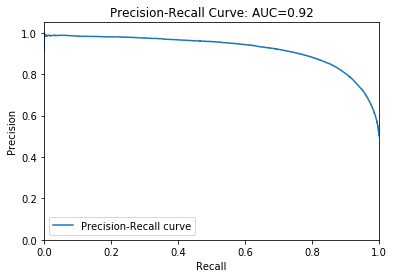

Wall time: 1.06 s


In [58]:
%%time
score_NB(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)

In [59]:
beep()

In [60]:
dump(clf, 'joblib_data/clf_nb_nostemmer.joblib') 

['joblib_data/clf_nb_nostemmer.joblib']

### NLTK

#### Porter

In [61]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

Wall time: 205 ms


In [62]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, work, love, product, veri, not, perfect, fit, work great, excel, nice, use, like, price, well, case, phone, one, easi, great product, look, qualiti, thank, game, instal, tast, best, time, buy, need, veri good, get, realli, awesom, make, recommend, expect, perfectli, much, littl, describ, good product, delici, better, light, ok, replac, bought, fast


Train Accuracy       0.85380
Test Accuracy        0.84686
Test Precision       0.86145
Test Recall          0.82684
F1                   0.84379
F2                   0.83354
P/R AUC              0.91987
             precision    recall  f1-score   support

      False    0.83338   0.86690   0.84981    164923
       True    0.86145   0.82684   0.84379    165077

avg / total    0.84742   0.84686   0.84680    330000



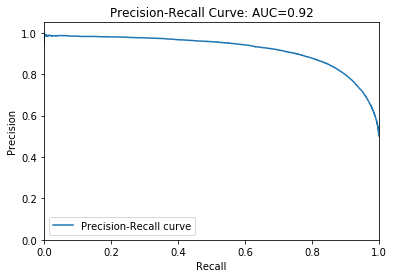

Wall time: 988 ms


In [63]:
%%time
score_NB(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

In [64]:
dump(clf, 'joblib_data/clf_nb_porter.joblib') 

['joblib_data/clf_nb_porter.joblib']

#### Lancaster

In [65]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

Wall time: 206 ms


In [66]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, work, lov, perfect, produc, very, not, excel, fit, us, work gre, nic, lik, pric, wel, easy, cas, phon, on, gre produc, look, qual, thank, gam, instal, tast, best, real, buy, tim, nee, very good, get, awesom, protect, mak, recommend, expect, charg, much, describ, littl, good produc, light, delicy, car, bet, fast, replac


Train Accuracy       0.85228
Test Accuracy        0.84546
Test Precision       0.86081
Test Recall          0.82436
F1                   0.84219
F2                   0.83140
P/R AUC              0.91862
             precision    recall  f1-score   support

      False    0.83134   0.86657   0.84859    164923
       True    0.86081   0.82436   0.84219    165077

avg / total    0.84608   0.84546   0.84539    330000



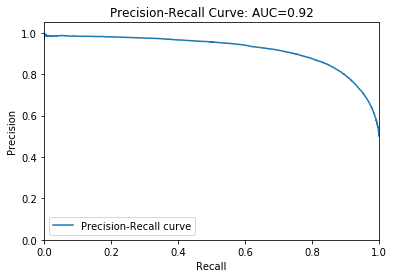

Wall time: 990 ms


In [67]:
%%time
score_NB(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

In [68]:
dump(clf, 'joblib_data/clf_nb_lancaster.joblib') 

['joblib_data/clf_nb_lancaster.joblib']

###  PyStemmer

In [69]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_pystemmer, y_train)

Wall time: 203 ms


In [70]:
print_top_features(tfidf_vect_pystemmer, clf, 50)

Most discriminative features:
 great, good, work, love, perfect, product, veri, not, fit, excel, use, nice, like, price, well, case, works great, one, easi, great product, look, phone, qualiti, thank, instal, game, tast, best, need, time, buy, very good, get, realli, awesom, make, flavor, recommend, expect, much, littl, good product, light, describ, delici, better, replac, ok, bought, fast


Train Accuracy       0.85451
Test Accuracy        0.84748
Test Precision       0.86191
Test Recall          0.82770
F1                   0.84446
F2                   0.83433
P/R AUC              0.92034
             precision    recall  f1-score   support

      False    0.83413   0.86727   0.85038    164923
       True    0.86191   0.82770   0.84446    165077

avg / total    0.84803   0.84748   0.84742    330000



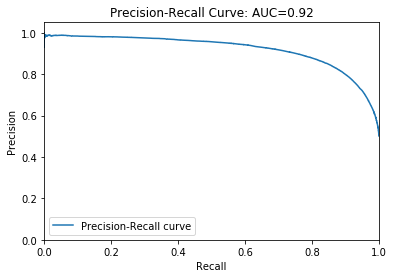

Wall time: 986 ms


In [71]:
%%time
score_NB(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)

In [72]:
dump(clf, 'joblib_data/clf_nb_pystemmer.joblib') 

['joblib_data/clf_nb_pystemmer.joblib']

## Random forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

### No stemmer

In [78]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer, y_train)

Wall time: 41min 59s


In [80]:
train_score = clf.score(X_train_tfidf_nostemmer, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_nostemmer, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.5316611940298508, test accuracy: 0.5324060606060607


In [82]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

Wall time: 18.5 s


In [84]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_nostemmer.joblib")

             precision    recall  f1-score   support

      False    0.81652   0.89169   0.85245    164923
       True    0.88083   0.79981   0.83837    165077

avg / total    0.84869   0.84573   0.84541    330000



['joblib_data/clf_random_forest_nostemmer.joblib']

### Porter

In [86]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter, y_train)

Wall time: 41min 59s


In [88]:
train_score = clf.score(X_train_tfidf_Porter, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_Porter, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.5339402985074627, test accuracy: 0.5334242424242425


In [90]:
%%time
predictions = clf.predict(X_test_tfidf_Porter)

Wall time: 18.2 s


In [92]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_porter.joblib")

             precision    recall  f1-score   support

      False    0.81661   0.89083   0.85211    164923
       True    0.88004   0.80014   0.83819    165077

avg / total    0.84834   0.84546   0.84514    330000



['joblib_data/clf_random_forest_porter.joblib']

Results are more encouraging! The problem is that it's way slower than Multinomial NB.

### Lancaster

In [94]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster, y_train)

Wall time: 42min 15s


In [96]:
train_score = clf.score(X_train_tfidf_Lancaster, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_Lancaster, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.5297567164179104, test accuracy: 0.5295454545454545


In [98]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster)

Wall time: 19.5 s


In [100]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_lancaster.joblib")

             precision    recall  f1-score   support

      False    0.81695   0.89208   0.85286    164923
       True    0.88127   0.80031   0.83884    165077

avg / total    0.84913   0.84617   0.84585    330000



['joblib_data/clf_random_forest_lancaster.joblib']

### Pystemmer

In [102]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer, y_train)

Wall time: 41min 5s


In [104]:
train_score = clf.score(X_train_tfidf_pystemmer, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_pystemmer, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.9843701492537313, test accuracy: 0.846169696969697


In [106]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer)

Wall time: 6.42 s


In [108]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_pystemmer.joblib")

             precision    recall  f1-score   support

      False    0.81695   0.89208   0.85286    164923
       True    0.88127   0.80031   0.83884    165077

avg / total    0.84913   0.84617   0.84585    330000



['joblib_data/clf_random_forest_pystemmer.joblib']

## TruncatedSVD
The X_train vector has around 20k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

### No stemmer

In [120]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_nostemmer_svd = tsvd.fit_transform(X_train_tfidf_nostemmer)
X_test_tfidf_nostemmer_svd = tsvd.transform(X_test_tfidf_nostemmer)

Wall time: 1min 33s


### Porter

In [121]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_Porter_svd = tsvd.fit_transform(X_train_tfidf_Porter)
X_test_tfidf_Porter_svd = tsvd.transform(X_test_tfidf_Porter)

Wall time: 1min 32s


### Lancaster

In [122]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_Lancaster_svd = tsvd.fit_transform(X_train_tfidf_Lancaster)
X_test_tfidf_Lancaster_svd = tsvd.transform(X_test_tfidf_Lancaster)

Wall time: 1min 32s


### Pystemmer

In [123]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_pystemmer_svd = tsvd.fit_transform(X_train_tfidf_pystemmer)
X_test_tfidf_pystemmer_svd = tsvd.transform(X_test_tfidf_pystemmer)

Wall time: 1min 30s


#### Store SVD-transformed dataset

In [124]:
dump(X_train_tfidf_nostemmer_svd, 'joblib_data/X_train_tfidf_nostemmer_svd.joblib')
dump(X_test_tfidf_nostemmer_svd, 'joblib_data/X_test_tfidf_nostemmer_svd.joblib')

['joblib_data/X_test_tfidf_nostemmer_svd.joblib']

In [125]:
dump(X_train_tfidf_Porter_svd, 'joblib_data/X_train_tfidf_Porter_svd.joblib')
dump(X_test_tfidf_Porter_svd, 'joblib_data/X_test_tfidf_Porter_svd.joblib')

['joblib_data/X_test_tfidf_Porter_svd.joblib']

In [126]:
dump(X_train_tfidf_Lancaster_svd, 'joblib_data/X_train_tfidf_Lancaster_svd.joblib')
dump(X_test_tfidf_Lancaster_svd, 'joblib_data/X_test_tfidf_Lancaster_svd.joblib')

['joblib_data/X_test_tfidf_Lancaster_svd.joblib']

In [127]:
dump(X_train_tfidf_pystemmer_svd, 'joblib_data/X_train_tfidf_pystemmer_svd.joblib')
dump(X_test_tfidf_pystemmer_svd, 'joblib_data/X_test_tfidf_pystemmer_svd.joblib')

['joblib_data/X_test_tfidf_pystemmer_svd.joblib']

## Random Forest with TruncatedSVD Dataset

### No stemmer

In [128]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 3min 8s


In [129]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 2.17 s


In [130]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.79154   0.84088   0.81546    164923
       True    0.83047   0.77875   0.80378    165077

avg / total    0.81101   0.80980   0.80962    330000



['joblib_data/clf_random_forest_nostemmer_svd.joblib']

### Porter

In [131]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 3min 6s


In [132]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 2.33 s


In [133]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_porter_svd.joblib")

             precision    recall  f1-score   support

      False    0.78808   0.84415   0.81515    164923
       True    0.83238   0.77321   0.80170    165077

avg / total    0.81024   0.80866   0.80842    330000



['joblib_data/clf_random_forest_porter_svd.joblib']

### Lancaster

In [134]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 3min 7s


In [135]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 2.31 s


In [136]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_lancaster_svd.joblib")

             precision    recall  f1-score   support

      False    0.78603   0.84345   0.81373    164923
       True    0.83128   0.77062   0.79980    165077

avg / total    0.80867   0.80702   0.80676    330000



['joblib_data/clf_random_forest_lancaster_svd.joblib']

### Pystemmer

In [137]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 3min 12s


In [138]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 2.2 s


In [139]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.79082   0.84416   0.81662    164923
       True    0.83306   0.77692   0.80401    165077

avg / total    0.81195   0.81052   0.81031    330000



['joblib_data/clf_random_forest_pystemmer_svd.joblib']

## LinearSVC

In [140]:
from sklearn import svm

### No_stemmer

In [141]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 3min 53s


In [142]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 125 ms


In [143]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.80463   0.83044   0.81733    164923
       True    0.82499   0.79855   0.81155    165077

avg / total    0.81481   0.81448   0.81444    330000



['joblib_data/clf_linearsvc_nostemmer_svd.joblib']

### Porter

In [144]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 5min 32s


In [145]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 125 ms


In [146]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_porter_svd.joblib")

             precision    recall  f1-score   support

      False    0.80569   0.82834   0.81686    164923
       True    0.82355   0.80041   0.81181    165077

avg / total    0.81462   0.81437   0.81433    330000



['joblib_data/clf_linearsvc_porter_svd.joblib']

### Lancaster

In [147]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 3min 54s


In [148]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 125 ms


In [149]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_lancaster_svd.joblib")

             precision    recall  f1-score   support

      False    0.80494   0.82326   0.81400    164923
       True    0.81932   0.80069   0.80990    165077

avg / total    0.81213   0.81197   0.81195    330000



['joblib_data/clf_linearsvc_lancaster_svd.joblib']

### Pystemmer

In [150]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 3min 53s


In [151]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 125 ms


In [152]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.80512   0.82688   0.81586    164923
       True    0.82224   0.80004   0.81099    165077

avg / total    0.81369   0.81345   0.81342    330000



['joblib_data/clf_linearsvc_pystemmer_svd.joblib']

## SVC

### No stemmer

In [153]:
clf = svm.SVC(random_state=42, max_iter=500)

In [154]:
%%time
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 2min 55s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [155]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 1min 9s


In [156]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.69579   0.07123   0.12923    164923
       True    0.51080   0.96889   0.66894    165077

avg / total    0.60325   0.52027   0.39921    330000



['joblib_data/clf_svc_nostemmer_svd.joblib']

### Porter

In [157]:
clf = svm.SVC(random_state=42, max_iter=500)

In [158]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 2min 55s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [159]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 1min 9s


In [160]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_porter_svd.joblib")

             precision    recall  f1-score   support

      False    0.56011   0.00240   0.00478    164923
       True    0.50036   0.99812   0.66657    165077

avg / total    0.53022   0.50049   0.33583    330000



['joblib_data/clf_svc_porter_svd.joblib']

### Lancaster

In [161]:
clf = svm.SVC(random_state=42, max_iter=500)

In [162]:
%%time
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 2min 55s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [163]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 1min 9s


In [164]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_lancaster_svd.joblib")

             precision    recall  f1-score   support

      False    0.31743   0.00480   0.00946    164923
       True    0.49884   0.98968   0.66334    165077

avg / total    0.40818   0.49747   0.33655    330000



['joblib_data/clf_svc_lancaster_svd.joblib']

### Pystemmer

In [165]:
clf = svm.SVC(random_state=42, max_iter=500)

In [166]:
%%time
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 2min 55s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [167]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 1min 9s


In [168]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.38011   0.02178   0.04120    164923
       True    0.49671   0.96451   0.65573    165077

avg / total    0.43843   0.49337   0.34861    330000



['joblib_data/clf_svc_pystemmer_svd.joblib']

## Adaboost
### 10 estimators

In [169]:
from sklearn.ensemble import AdaBoostClassifier

In [170]:
%%time
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 3min 29s


In [171]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test, predictions, digits=5))

             precision    recall  f1-score   support

      False    0.70243   0.75681   0.72860    164923
       True    0.73667   0.67969   0.70703    165077

avg / total    0.71956   0.71823   0.71781    330000

Wall time: 1.06 s


### 15 estimators

In [172]:
%%time
clf = AdaBoostClassifier(n_estimators=15, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 5min 13s


In [173]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test, predictions, digits=5))

             precision    recall  f1-score   support

      False    0.71512   0.75441   0.73424    164923
       True    0.74039   0.69974   0.71949    165077

avg / total    0.72776   0.72706   0.72686    330000

Wall time: 1.45 s


Increasing the number of estimators did not lead to an improvement in performances: let's see what happens when we reduce them.
## 20 estimators

In [174]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 6min 56s


In [175]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test, predictions, digits=5))

             precision    recall  f1-score   support

      False    0.72422   0.77225   0.74746    164923
       True    0.75631   0.70621   0.73040    165077

avg / total    0.74028   0.73921   0.73893    330000

Wall time: 1.84 s


In [176]:
beep()

Performances are a bit better. Apparently the best configuration is the "20 estimators" one. Let's now build predictive models for all 4 representations.

## 20 Estimators
### No stemming

In [177]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 6min 58s


In [178]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 1.81 s


In [179]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.73023   0.77194   0.75051    164923
       True    0.75836   0.71508   0.73609    165077

avg / total    0.74430   0.74350   0.74329    330000



['joblib_data/clf_adaboost_nostemmer_svd.joblib']

### Porter

In [180]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 6min 58s


In [181]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 1.8 s


In [182]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_porter_svd.joblib")

             precision    recall  f1-score   support

      False    0.72422   0.77225   0.74746    164923
       True    0.75631   0.70621   0.73040    165077

avg / total    0.74028   0.73921   0.73893    330000



['joblib_data/clf_adaboost_porter_svd.joblib']

### Lancaster

In [183]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 6min 57s


In [184]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 1.8 s


In [185]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_Lancaster_svd.joblib")

             precision    recall  f1-score   support

      False    0.73054   0.76782   0.74871    164923
       True    0.75557   0.71705   0.73581    165077

avg / total    0.74306   0.74242   0.74226    330000



['joblib_data/clf_adaboost_Lancaster_svd.joblib']

### Pystemmer

In [186]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 6min 57s


In [187]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 1.8 s


In [188]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False    0.73939   0.76039   0.74974    164923
       True    0.75362   0.73225   0.74278    165077

avg / total    0.74651   0.74631   0.74626    330000



['joblib_data/clf_adaboost_pystemmer_svd.joblib']